In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import norm

# R3: **Single Product Pricing in Adversarial Environment**

Develop a robust pricing algorithm for a single product that works effectively against **adversarial environments** where buyer valuations can be strategically chosen to maximize the company's regret.


##  **ADVERSARIAL BUYER MODEL**

**Adversarial Buyer**: Unlike stochastic environments (R1/R2), the adversarial buyer has a **predefined sequence of valuations** that can be strategically chosen by an adversary to **maximize the company's regret**.


In [22]:
class AdversarialBuyer:
    def __init__(self, valuation_sequence):
        """
        Represents an adversarial buyer with a predefined sequence of valuations.
        :param valuation_sequence: Array of valuations for each round
        """
        self.valuation_sequence = valuation_sequence
        self.t = 0
        
    def round(self, price):
        """
        Returns whether the buyer purchases at the given price based on current valuation.
        :param price: Offered price
        :return: 1 if buyer accepts (valuation > price), 0 otherwise
        """
        if self.t >= len(self.valuation_sequence):
            # If we've exhausted the sequence, return 0
            return 0
            
        valuation = self.valuation_sequence[self.t]
        self.t += 1
        return 1 if price < valuation else 0
    
    def reset(self):
        """Reset the time counter for multiple experiments"""
        self.t = 0

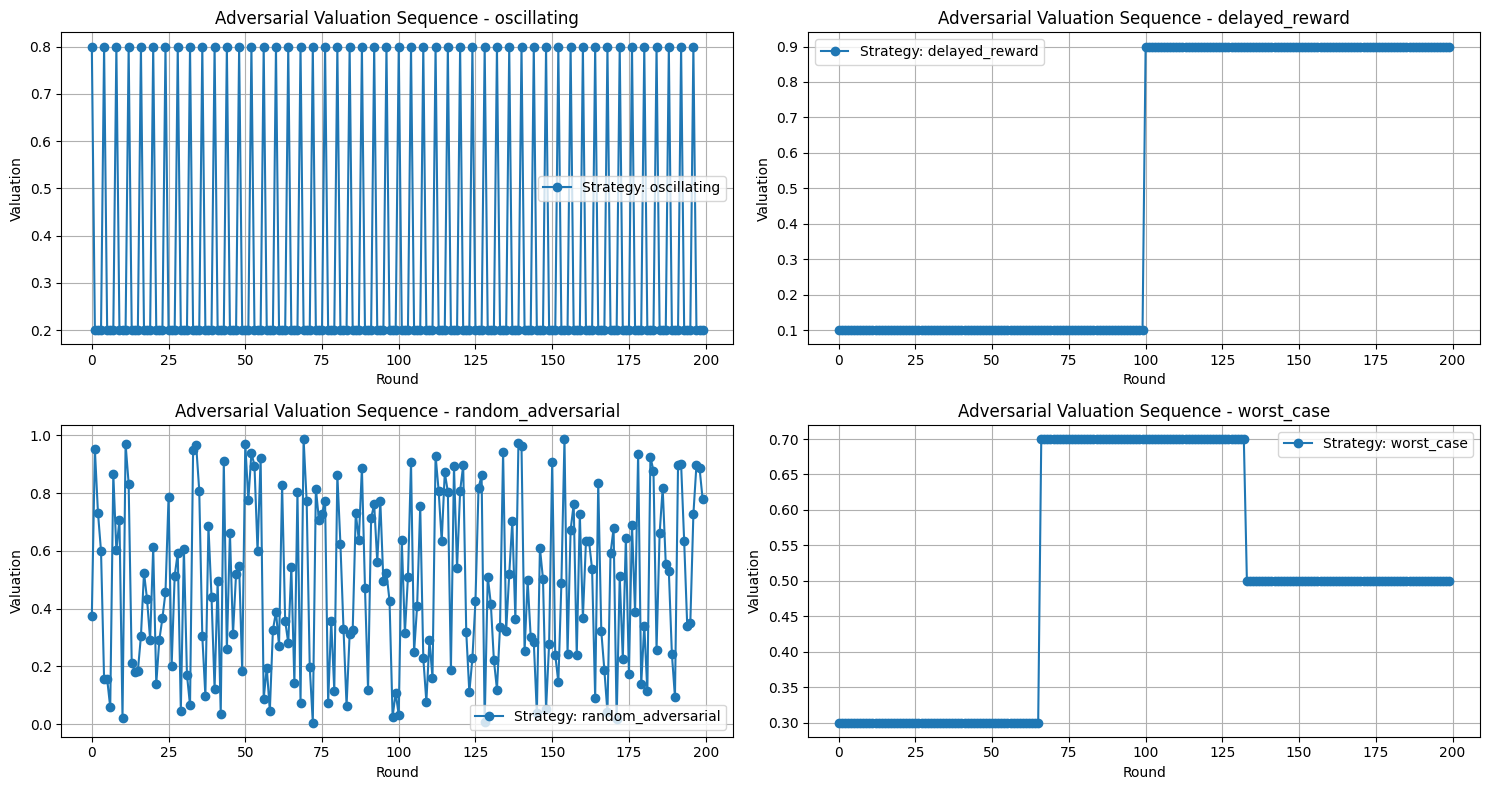

In [23]:
# Example: Generate adversarial valuation sequences
def generate_adversarial_sequence(T, strategy):
    """
    Generate adversarial valuation sequences to challenge learning algorithms.
    
    :param T: Number of rounds
    :param strategy: Type of adversarial strategy
    :return: Array of valuations
    """
    if strategy == 'oscillating':
        # Alternates between high and low valuations to confuse the algorithm
        return np.array([0.8 if t % 4 == 0 else 0.2 for t in range(T)])
    
    elif strategy == 'delayed_reward':
        # Low valuations initially, then high valuations later
        return np.concatenate([np.full(T//2, 0.1), np.full(T//2, 0.9)])
    
    elif strategy == 'random_adversarial':
        # Pseudo-random but deterministic sequence
        np.random.seed(42)  # Fixed seed for reproducibility
        return np.random.uniform(0, 1, T)
    
    elif strategy == 'worst_case':
        # Designed to maximize regret against common algorithms
        sequence = np.zeros(T)
        for t in range(T):
            # Pattern that punishes exploration
            if t < T // 3:
                sequence[t] = 0.3
            elif t < 2 * T // 3:
                sequence[t] = 0.7
            else:
                sequence[t] = 0.5
        return sequence
    
    else:
        raise ValueError(f"Unknown strategy: {strategy}")

# Test the adversarial buyer
T_test = 200
strategies = ['oscillating', 'delayed_reward', 'random_adversarial', 'worst_case']

fig, axes = plt.subplots(2, 2, figsize=(15, 8))
axes = axes.flatten()

for i, strategy in enumerate(strategies):
    #plotting the adversarial valuation sequence
    valuation_sequence = generate_adversarial_sequence(T_test, strategy)    
    axes[i].plot(valuation_sequence, marker='o', label=f'Strategy: {strategy}')
    axes[i].set_title(f'Adversarial Valuation Sequence - {strategy}')
    axes[i].set_xlabel('Round')
    axes[i].set_ylabel('Valuation')
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()
plt.show()

##  **COMPANY STRATEGY: EXP3 Algorithm**

**EXP3**  where no distributional assumptions can be made.


In [24]:
class CompanyEXP3:
  def __init__(self, K, B, T):
    """
    EXP3 algorithm adapted for adversarial bandits with budget constraints.
    
    :param K: Number of arms (prices)
    :param B: Total budget
    :param T: Time horizon
    :param gamma: Exploration parameter (if None, uses theoretical optimal)
    :param eta: Learning rate (if None, uses theoretical optimal)
    """
    self.K = K
    self.T = T
    self.budget = B
    self.initial_budget = B
    self.rho = B / T  # Budget rate
    self.t = 0
    self.p_t = None
    
    self.gamma = min(1, np.sqrt(K * np.log(K) / ((np.e - 1) * T)))
    self.eta = np.sqrt(np.log(K) / (K * T))
    
    # Initialize weights and estimated rewards
    self.weights = np.ones(K)
    self.estimated_rewards = np.zeros(K)
    self.estimated_costs = np.zeros(K)
    self.probabilities = np.ones(K) / K
    
    print(f"EXP3 initialized with γ={self.gamma:.4f}, η={self.eta:.4f}")

  def pull_arm(self):
    """
    Select an arm using EXP3 with budget-aware probability distribution.
    """
    if self.budget < 1:
      self.p_t = 0  # Default to lowest price when budget exhausted
      return 0
    
    # Compute EXP3 probabilities
    # EXP3 probability update
    exp_weights = np.exp(self.eta * self.estimated_rewards)
    self.weights = exp_weights
    # Normalize to get probabilities with exploration
    sum_weights = np.sum(self.weights)
    self.probabilities = (1 - self.gamma) * (self.weights / sum_weights) + self.gamma / self.K
    
    # Budget-aware arm selection using linear programming approach
    # similar to UCB but with EXP3 probabilities as baseline
    if self.t > 0:
      gamma_budget = self._compute_budget_aware_distribution()
      self.p_t = np.random.choice(self.K, p=gamma_budget)
    else:
      self.p_t = np.random.choice(self.K, p=self.probabilities)
    
    return self.p_t


  def _compute_budget_aware_distribution(self):
    """
    Compute budget-aware probability distribution combining EXP3 with budget constraints.
    """
    # Remaining budget rate
    remaining_rounds = max(1, self.T - self.t)
    current_rho = self.budget / remaining_rounds
    
    # If we have plenty of budget, use pure EXP3
    if current_rho >= self.rho:
      return self.probabilities
    
    # Otherwise, solve constrained optimization similar to UCB approach
    # but using EXP3 probabilities as the objective
    try:
      # Objective: maximize expected utility weighted by EXP3 probabilities
      # We approximate this by using estimated rewards
      c = -self.estimated_rewards  # Negative for maximization
      
      # Budget constraint: expected cost <= current budget rate
      A_ub = [self.estimated_costs]
      b_ub = [current_rho]
      
      # Probability constraint
      A_eq = [np.ones(self.K)]
      b_eq = [1]
      
      bounds = [(0, 1)] * self.K
      
      res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, 
                           bounds=bounds, method='highs')
      
      if res.success:
        # Blend with EXP3 probabilities for exploration
        blend_factor = 0.7  # How much to trust the LP solution
        gamma_budget = blend_factor * res.x + (1 - blend_factor) * self.probabilities
        return gamma_budget / np.sum(gamma_budget)  # Renormalize
      else:
        return self.probabilities
    except:
      # Fallback to EXP3 probabilities if optimization fails
      return self.probabilities

  def update(self, f_t, c_t):
    """
    Update the algorithm with observed reward and cost.
    
    :param f_t: Observed reward (revenue)
    :param c_t: Observed cost (units sold)
    """
    self.t += 1
    self.budget -= c_t
    
    # EXP3 importance-weighted reward estimation
    if self.probabilities[self.p_t] > 0:
      # Importance-weighted estimator
      reward_estimate = f_t / self.probabilities[self.p_t]
      cost_estimate = c_t / self.probabilities[self.p_t]
      
      # Update estimated rewards for the selected arm
      self.estimated_rewards[self.p_t] += reward_estimate
      self.estimated_costs[self.p_t] = (self.estimated_costs[self.p_t] * (self.t - 1) + cost_estimate) / self.t
    
    # Clip estimates to prevent explosion
    self.estimated_rewards = np.clip(self.estimated_rewards, -10, 10)
    self.estimated_costs = np.clip(self.estimated_costs, 0, 2)

  def get_algorithm_state(self):
    """Return current state for debugging/analysis."""
    return {
      'weights': self.weights.copy(),
      'probabilities': self.probabilities.copy(),
      'estimated_rewards': self.estimated_rewards.copy(),
      'estimated_costs': self.estimated_costs.copy(),
      'budget': self.budget,
      'round': self.t
    }

## SIMULATION

In [25]:
def compute_best_price_adversarial(prices, rho, valuation_sequence):
    """
    Compute optimal randomized pricing strategy for adversarial environment.
    For adversarial environment, we compute the theoretical benchmark against
    the valuation sequence.
    
    Parameters:
    - prices: list or array of possible prices
    - rho: budget constraint (B/T)
    - valuation_sequence: adversarial valuation sequence
    
    Returns:
    - gamma: optimal price distribution 
    - expected_revenue: expected revenue under strategy
    - expected_units_sold: expected units sold under strategy
    """
    prices = np.array(prices)
    T = len(valuation_sequence)
    
    # For each price, compute win probability against adversarial sequence
    win_probabilities = np.zeros(len(prices))
    for i, price in enumerate(prices):
        win_probabilities[i] = np.mean(valuation_sequence > price)
    
    print(f"Win probabilities against adversarial sequence: {win_probabilities}")
    
    # If no constraint is binding, choose best price
    revenues = prices * win_probabilities
    if np.max(win_probabilities) <= rho:
        gamma = np.zeros(len(prices))
        gamma[np.argmax(revenues)] = 1.0
        return gamma, np.max(revenues), np.max(win_probabilities)
    
    # Solve linear program for constrained case
    c = -revenues  # Negate for minimization
    
    # Constraint: expected units sold ≤ rho
    A_ub = [win_probabilities]
    b_ub = [rho]
    
    # Constraint: gamma is a probability distribution
    A_eq = [np.ones(len(prices))]
    b_eq = [1]
    
    bounds = [(0, 1)] * len(prices)
    
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub,
                           A_eq=A_eq, b_eq=b_eq,
                           bounds=bounds, method='highs')
    
    if res.success:
        gamma = res.x
        expected_revenue = -res.fun
        expected_units_sold = np.sum(gamma * win_probabilities)
        return gamma, expected_revenue, expected_units_sold
    else:
        # Fallback: choose best unconstrained price
        gamma = np.zeros(len(prices))
        gamma[np.argmax(revenues)] = 1.0
        return gamma, np.max(revenues), win_probabilities[np.argmax(revenues)]

In [26]:
T = 10000
B = 4000
P = np.linspace(0, 1, 11)
K = len(P)

# Generate adversarial valuation sequence
adversarial_strategy = 'oscillating'  # Can be changed to test different strategies
valuation_sequence = generate_adversarial_sequence(T, adversarial_strategy)

# Compute optimal benchmark against this adversarial sequence
gamma, exp_utility, expected_units_sold = compute_best_price_adversarial(P, B/T, valuation_sequence)
print(f"Adversarial strategy: {adversarial_strategy}")
print(f"Gamma: {gamma}")
print(f"Expected utility: {exp_utility}")
print(f"Expected unit sold: {expected_units_sold}")

n_trials = 10

regret_per_trial = []

for seed in range(n_trials):
  np.random.seed(seed)

  # Create adversarial buyer with the predefined sequence
  buyer = AdversarialBuyer(valuation_sequence)
  agent = CompanyEXP3(K=K, B=B, T=T)
  ag_utility = np.zeros(T)

  flag = True
  for i in range(T):
    arm = agent.pull_arm()
    price = P[arm]

    sold = buyer.round(price)

    f_t = price if sold else 0        # reward: revenue
    c_t = 1 if sold else 0            # cost: unit consumed

    agent.update(f_t=f_t, c_t=c_t)

    ag_utility[i] = f_t

    if agent.budget <= 0 and flag:
      print("TRIAL", seed , "Budget exhausted at round", i)
      flag = False

  # Reset buyer for next trial
  buyer.reset()
  
  cumulative_regret = np.cumsum(exp_utility-ag_utility)
  regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_std = regret_per_trial.std(axis=0)

print("Agent Cumulative Reward", np.sum(ag_utility))
print("Average cumulative regret", average_regret[-1])

Win probabilities against adversarial sequence: [1.   1.   0.25 0.25 0.25 0.25 0.25 0.25 0.   0.   0.  ]
Adversarial strategy: oscillating
Gamma: [ 0.  0.  0.  0.  0.  0. -0.  1.  0.  0.  0.]
Expected utility: 0.17500000000000002
Expected unit sold: 0.25
EXP3 initialized with γ=0.0392, η=0.0047
EXP3 initialized with γ=0.0392, η=0.0047
EXP3 initialized with γ=0.0392, η=0.0047
EXP3 initialized with γ=0.0392, η=0.0047
EXP3 initialized with γ=0.0392, η=0.0047
EXP3 initialized with γ=0.0392, η=0.0047
EXP3 initialized with γ=0.0392, η=0.0047
EXP3 initialized with γ=0.0392, η=0.0047
EXP3 initialized with γ=0.0392, η=0.0047
EXP3 initialized with γ=0.0392, η=0.0047
EXP3 initialized with γ=0.0392, η=0.0047
EXP3 initialized with γ=0.0392, η=0.0047
EXP3 initialized with γ=0.0392, η=0.0047
EXP3 initialized with γ=0.0392, η=0.0047
EXP3 initialized with γ=0.0392, η=0.0047
EXP3 initialized with γ=0.0392, η=0.0047
EXP3 initialized with γ=0.0392, η=0.0047
EXP3 initialized with γ=0.0392, η=0.0047
EXP3 in

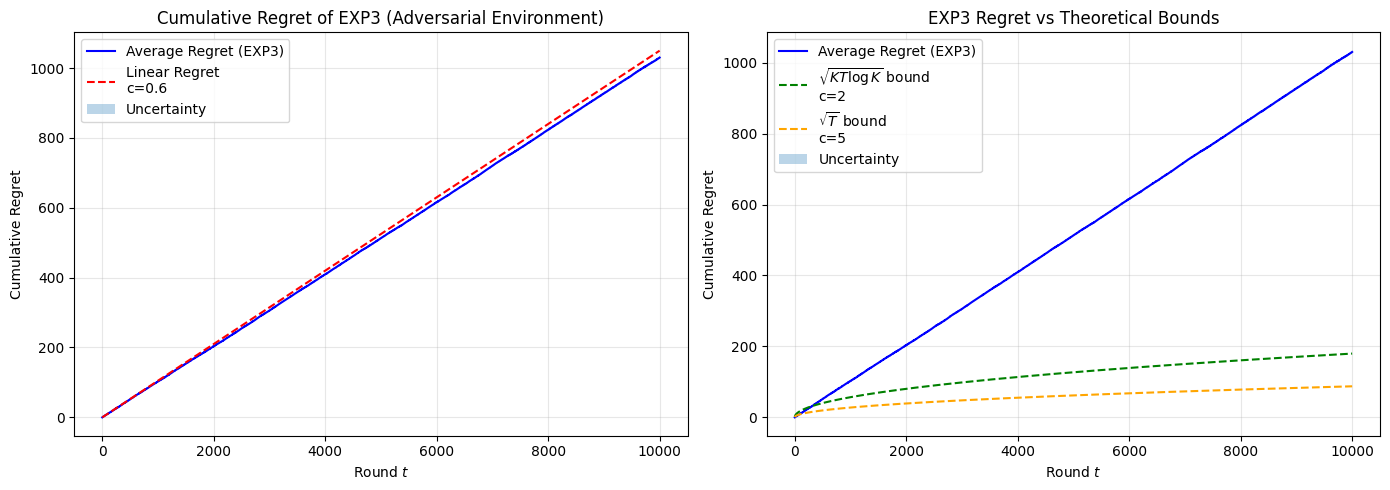


Algorithm Performance Summary:
- Adversarial strategy used: oscillating
- Final average regret: 1030.15
- Regret per round (final): 0.1030
- Theoretical EXP3 bound achieved: False
- Total budget utilization: 79.9%


In [27]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# First subplot: Cumulative regret with linear line 
axs[0].plot(np.arange(T), average_regret, label='Average Regret (EXP3)', color='blue')
axs[0].set_title('Cumulative Regret of EXP3 (Adversarial Environment)')

c_linear = 0.6
linear_regret = np.arange(T) * exp_utility * c_linear # Linear regret line
axs[0].plot(np.arange(T), linear_regret, label=f'Linear Regret\nc={c_linear}', linestyle='--', color='red')
axs[0].fill_between(
    np.arange(T),
    average_regret - regret_std / np.sqrt(n_trials),
    average_regret + regret_std / np.sqrt(n_trials),
    alpha=0.3,
    label='Uncertainty'
)
axs[0].set_xlabel('Round $t$')
axs[0].set_ylabel('Cumulative Regret')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# Second subplot: EXP3 theoretical bounds
axs[1].plot(np.arange(T), average_regret, label='Average Regret (EXP3)', color='blue')
axs[1].set_title('EXP3 Regret vs Theoretical Bounds')

t_vals = np.arange(1, T+1)

# EXP3 theoretical bound: O(sqrt(KT log K))
c_exp3 = 2
exp3_bound = np.sqrt(K * t_vals * np.log(K)) * exp_utility * c_exp3
axs[1].plot(np.arange(T), exp3_bound, label=f'$\\sqrt{{KT\\log K}}$ bound\nc={c_exp3}', linestyle='--', color='green')

# Simpler sqrt(T) bound for comparison
c_sqrt = 5
sqrt_bound = np.sqrt(t_vals) * exp_utility * c_sqrt
axs[1].plot(np.arange(T), sqrt_bound, label=f'$\\sqrt{{T}}$ bound\nc={c_sqrt}', linestyle='--', color='orange')

# Fill between for uncertainty in the second plot
axs[1].fill_between(
    np.arange(T),
    average_regret - regret_std / np.sqrt(n_trials),
    average_regret + regret_std / np.sqrt(n_trials),
    alpha=0.3,
    label='Uncertainty'
)

# Set labels and legends for the second subplot
axs[1].set_xlabel('Round $t$')
axs[1].set_ylabel('Cumulative Regret')
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some algorithm statistics
print(f"\nAlgorithm Performance Summary:")
print(f"- Adversarial strategy used: {adversarial_strategy}")
print(f"- Final average regret: {average_regret[-1]:.2f}")
print(f"- Regret per round (final): {average_regret[-1]/T:.4f}")
print(f"- Theoretical EXP3 bound achieved: {average_regret[-1] <= exp3_bound[-1]}")
print(f"- Total budget utilization: {(B - agent.budget)/B * 100:.1f}%")